In [ ]:
# 資料權限
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
#%cd /content/drive/My-Drive/

#匯入所需套件
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

# 在線GPU性能检验
!nvidia-smi 

Mounted at /content/gdrive/
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#匯入資料
raw = pd.read_csv('/content/gdrive/MyDrive/科技部計畫/variables/Bitcoin Done_20150101-20220831.csv')
raw['Date'] = pd.to_datetime(raw.Date, format = '%Y/%m/%d')

#read the data
stock = raw 
amount = len(stock) 
stock = stock.loc[:,['Date','Close']]

,Date,Close
0,2015-01-01,314.248993
1,2015-01-02,315.032013
2,2015-01-03,281.082001
3,2015-01-04,264.195007
4,2015-01-05,274.473999
...,...,...
2795,2022-08-27,20041.738280
2796,2022-08-28,19616.814450
2797,2022-08-29,20297.994140
2798,2022-08-30,19796.808590


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#設定資料之input variable (X) 與target variable (Y)。如以被預測日前ref_day天作為input variables，以被預測日做為target variable
def xy_set(dataset, ref_day):
    predict_day=1 #predict_day:被預測天數
    X = [[0 for i in range(ref_day)] for j in range(dataset.shape[0]-predict_day-ref_day)] #宣告輸入變數空集合
    Y = [0 for j in range(dataset.shape[0]-predict_day-ref_day)] #宣告被預測變數空集合
    for i in range(dataset.shape[0]-predict_day-ref_day):
        X[i] = dataset[i:i+ref_day,0] #前ref_day天資料
        Y[i] = dataset[i+ref_day:i+ref_day+predict_day,0] #第ref_day+1天資料
    return np.array(X),np.array(Y)

In [ ]:
def show_train_history(train_history,train,validation):
   #train_history訓練過程；train訓練結果；validation驗證結果

      plt.plot(train_history.history[train]) #描繪訓練結果
      plt.plot(train_history.history[validation]) #描繪驗證結果
      plt.title('Train History') #圖標題
      plt.ylabel(train) #y軸標籤
      plt.xlabel('Epoch') #x軸標籤
      plt.legend(['train', 'validation'], loc='upper left') #設定訓練與驗證之圖例及位置
      plt.show()

In [ ]:
## 預設參數
ref_day = 5 #ref_day:預測參照天數
d = 0.2
dim= stock.shape[1]#-1
%pylab inline
#讓圖形直接顯示於jupyter note

rdf= pd.DataFrame() #用于保存所有股票的预测价格

## 
from sklearn import preprocessing #使用sklearn的preprocessing的MinMaxScaler進行正規化:(x-min)/(max-min)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def show_test_result(Real_data,Prediciton_data):
    plt.plot(Real_data, color="blue", label="Real Stock Price") #描繪測試資料真實股價
    plt.plot(Prediciton_data, color="red", label="Predicted Stock Price") #描繪測試資料預測股價
    plt.title('Stock Prediction')
    plt.ylabel('Price') 
    plt.xlabel('Time') 
    plt.legend()
    plt.show()

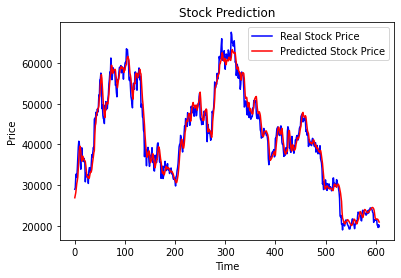

In [ ]:
stock.shape
for i in range(stock.shape[1]-1):
  n= i+1
  stock_set = stock[stock.columns[n]] 

  #分割訓練資料與測試資料
  length = len(stock[stock.Date<'2019-12-31'])-ref_day #決定分割時間點，例如以2021-01-31之前ref_day天以前之有交易記錄的資料為training set
  train = stock_set[0:length] #決定資料分割時間點，例如以2021-01-31前ref_day天起為testing set
  test = stock_set[length:]

  #使用sklearn的preprocessing的MinMaxScaler進行正規化:(x-min)/(max-min)
  #執行正規化
  train = train.values.reshape(-1,1) #執行reshape，使其shape為(資料長度,1)
  scaler= preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(train)
  train_nom = scaler.transform(train) #執行正規化，使得特徵值範圍介於0~1

  X_train, Y_train = xy_set(train_nom, ref_day) #區分訓練資料之input variables與output variable
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # 轉成三維，以便符合keras recurrent之input_shape
  Y_train = np.squeeze(Y_train)
  print('輸入變數維度',X_train.shape)
  print('預測變數維度',Y_train.shape)
  print('第Y個被預測日之前ref_day天每天正規化股價')
  print(X_train[4])
  print('第Y個預測日之正規化股價')
  print(Y_train[4])

  model = Sequential()
  model.add(LSTM(units=256, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(d))
  model.add(LSTM(units=256, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], dim)))
  model.add(Dropout(d))
  model.add(LSTM(units=256, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], dim)))
  model.add(Dropout(d))
  model.add(LSTM(units=256, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], dim)))
  model.add(Dropout(d))
  model.add(LSTM(units=256, activation="relu", return_sequences=False, input_shape=(X_train.shape[1], dim)))
  model.add(Dropout(d))  
  model.add(Dense(units=1))
      #model.compile(optimizer='adam', loss='mse')  # rmsprop
      #model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error']) 
      # 屬迴歸分析，通常使用Mean Squared Error或Mean Absolute Error
  model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
  model.summary()
  train_history =model.fit(X_train, Y_train,batch_size=32,  
                         epochs=100,verbose=1,validation_split=0.2)
  
  show_train_history(train_history,'mean_squared_error','val_mean_squared_error')

  #分割訓練資料與測試資料
  length = len(stock[stock.Date<'2020-12-31'])-ref_day #決定分割時間點，例如以2021-01-31之前的ref_day天以後之有交易記錄的資料為testing set
  test = stock_set[length:]
  #執行正規化
  test = test.values.reshape(-1,1) #執行reshape，使其shape為(資料長度,1)
  test_scaler= preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(test)
  test_nom = test_scaler.transform(test) #執行正規化，使得特徵值範圍介於0~1

  X_test, Y_test = xy_set(test_nom, ref_day) #區分訓練資料之input variables與output variable
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 轉成三維，以便符合keras recurrent之input_shape
  Y_test = np.squeeze(Y_test)
  print('輸入變數維度',X_test.shape)
  print('預測變數維度',Y_test.shape)
  print('第Y個被預測日之前ref_day天每天正規化股價')
  print(X_test[4])
  print('第Y個預測日之正規化股價')
  print(Y_test[4])

  scores = model.evaluate(X_test, Y_test, verbose=1) #使用model.evaluate進行模型評估，評估後的績效指標會儲存於scores
  scores[1] #傳回測試資料的mean_absolute_error

  Y_test_predict=model.predict(X_test) #測試資料預測結果
  Y_test_predict_price = test_scaler.inverse_transform(Y_test_predict) # 將正規化預測值轉換為股票價格

  X_test_real, Y_test_real = xy_set(test, ref_day) #取得測試資料之被預測日之真實股票價格
  show_test_result(Y_test_real,Y_test_predict_price) #結果若不錯，代表可以使用此模型預測某支股票的股價

  col= stock.columns[n] 
  result= pd.DataFrame(Y_test_predict_price, columns= [col])
  rdf= pd.concat([rdf, result], axis=1)
  

In [ ]:
rdf

,Close
0,26917.078125
1,27544.005859
2,28184.876953
3,29260.955078
4,30457.677734
...,...
603,21695.519531
604,21640.123047
605,21480.478516
606,21211.521484


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/科技部計畫/variables')
print(os.getcwd() )#获取当前工作路径
timenow= time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
type(timenow) #str

outstr= 'LSTM_PricePredictPrice'+ timenow + '.csv'
rdf.to_csv(outstr) #相对位置，保存在getwcd()获得的路径下

outstr

/content/gdrive/MyDrive/科技部計畫/variables


'LSTM_PricePredictPrice2022-09-07 16:32:48.csv'